## 0. Import Necessary Modules

In [4]:
import os
import time

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import cv2 as cv

from altusi.utils.logger import *
import altusi.utils.visualizer as vis

In [6]:
import mxnet as mx
import gluoncv as gcv

## 1. Load SSDFace model

### 1.1 Specify Context

In [7]:
ctx = mx.context.gpu(0) if mx.context.num_gpus() else mx.context.cpu()

LOG(INFO, 'Device in Use:', ctx)

[2019-09-04 10:12:02] [INFO]  Device in Use: gpu(0)


### 1.2 Specify Classes

In [8]:
classes = ['person']

### 1.3 Load Model Parameters

In [9]:
net = gcv.model_zoo.get_model('ssd_300_vgg16_atrous_custom', classes=classes, ctx=ctx)
net.load_parameters('ssd_300_vgg16_atrous_voc_best.params')

net.collect_params().reset_ctx(ctx)
LOG(INFO, 'SSDFace Model loading done')

[2019-09-04 10:12:05] [INFO]  SSDFace Model loading done


## 2. Test with Images

In [16]:
def filter_bboxes(bboxes, scores, class_ids, thresh=0.8):
    ids = np.where(scores.asnumpy().reshape(-1) > thresh)[0]

    if len(ids):
        return bboxes[ids], scores[ids], class_ids[ids]
    else:
        return None, None, None


def ssd_predict(net, image, ctx, thresh=0.5):
    x, img = gcv.data.transforms.presets.ssd.transform_test(mx.nd.array(image), short=300)
    x = x.as_in_context(ctx)

    class_ids, scores, bboxes = net(x)

    if len(bboxes[0]) > 0:
        bboxes, scores, class_ids = filter_bboxes(bboxes[0], scores[0], class_ids[0], thresh)

        if bboxes is not None:
            classes = [net.classes[int(idx.asscalar())] for idx in class_ids]

    return class_ids, scores, bboxes, img

def rescale_bboxes(bboxes, dims, new_dims):
    H, W = dims
    _H, _W = new_dims
    
    _bboxes = []
    for bbox in bboxes:
        bbox = bbox.asnumpy()
        bbox = bbox / np.array([W, H, W, H]) * np.array([_W, _H, _W, _H])
        _bboxes.append(bbox)
        
    return _bboxes

### 2.1 Read and Test with Image

In [41]:
image_fname = '/path/to/image.jpg'

_, fname = os.path.split(image_fname)

# read and test
image = cv.imread(image_fname)
class_ids, scores, bboxes, ssd_image = ssd_predict(net, image, ctx)

if bboxes is not None:
    bboxes = rescale_bboxes(bboxes, ssd_image.shape[:2], image.shape[:2])

image = vis.drawObjects(image, bboxes, color=vis.COLOR_RED_LIGHT)

cv.imwrite(f'images/{fname}', image)

True

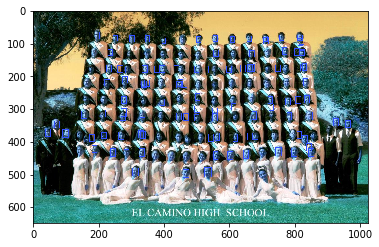

In [42]:
plt.imshow(image)